## Generate data with transient dynamic observations where experiment is concluded at steady state observation

In [1]:
from data.budworm import budworm_ode, simulate_trials
from scipy.integrate import solve_ivp
import numpy as np
import torch
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from tqdm.auto import tqdm
savefigs = False

## Create smooth control function

In [2]:
from sympy import symbols, Eq, solve, simplify

r, k = symbols('r k', positive=True)
a = r/k
b = -r
c = (k+r)/k
d = -r
p = (3*a*c-b**2) / (3*a**2)
q = (2*b**3 - 9*a*b*c+27*a**2*d) / (27*a**3)

D = - (4*p**3 + 27*q**2)
D = simplify(D)


D_fixed = D.subs(r, 0.56)
r1, r2 = solve(Eq(D_fixed, 0), k)
print(r1,r2)

k1 = r1-1.1
k2 = r2+1.1

def smooth_k(t):
    A = (k2-k1)/2
    return A*np.sin(t-np.pi/2)+A + k1

def smooth_k_torch(t):
    A = (k2-k1)/2
    return A*torch.sin(t-torch.pi/2) + A + k1

6.44569072482332 9.93441120446710


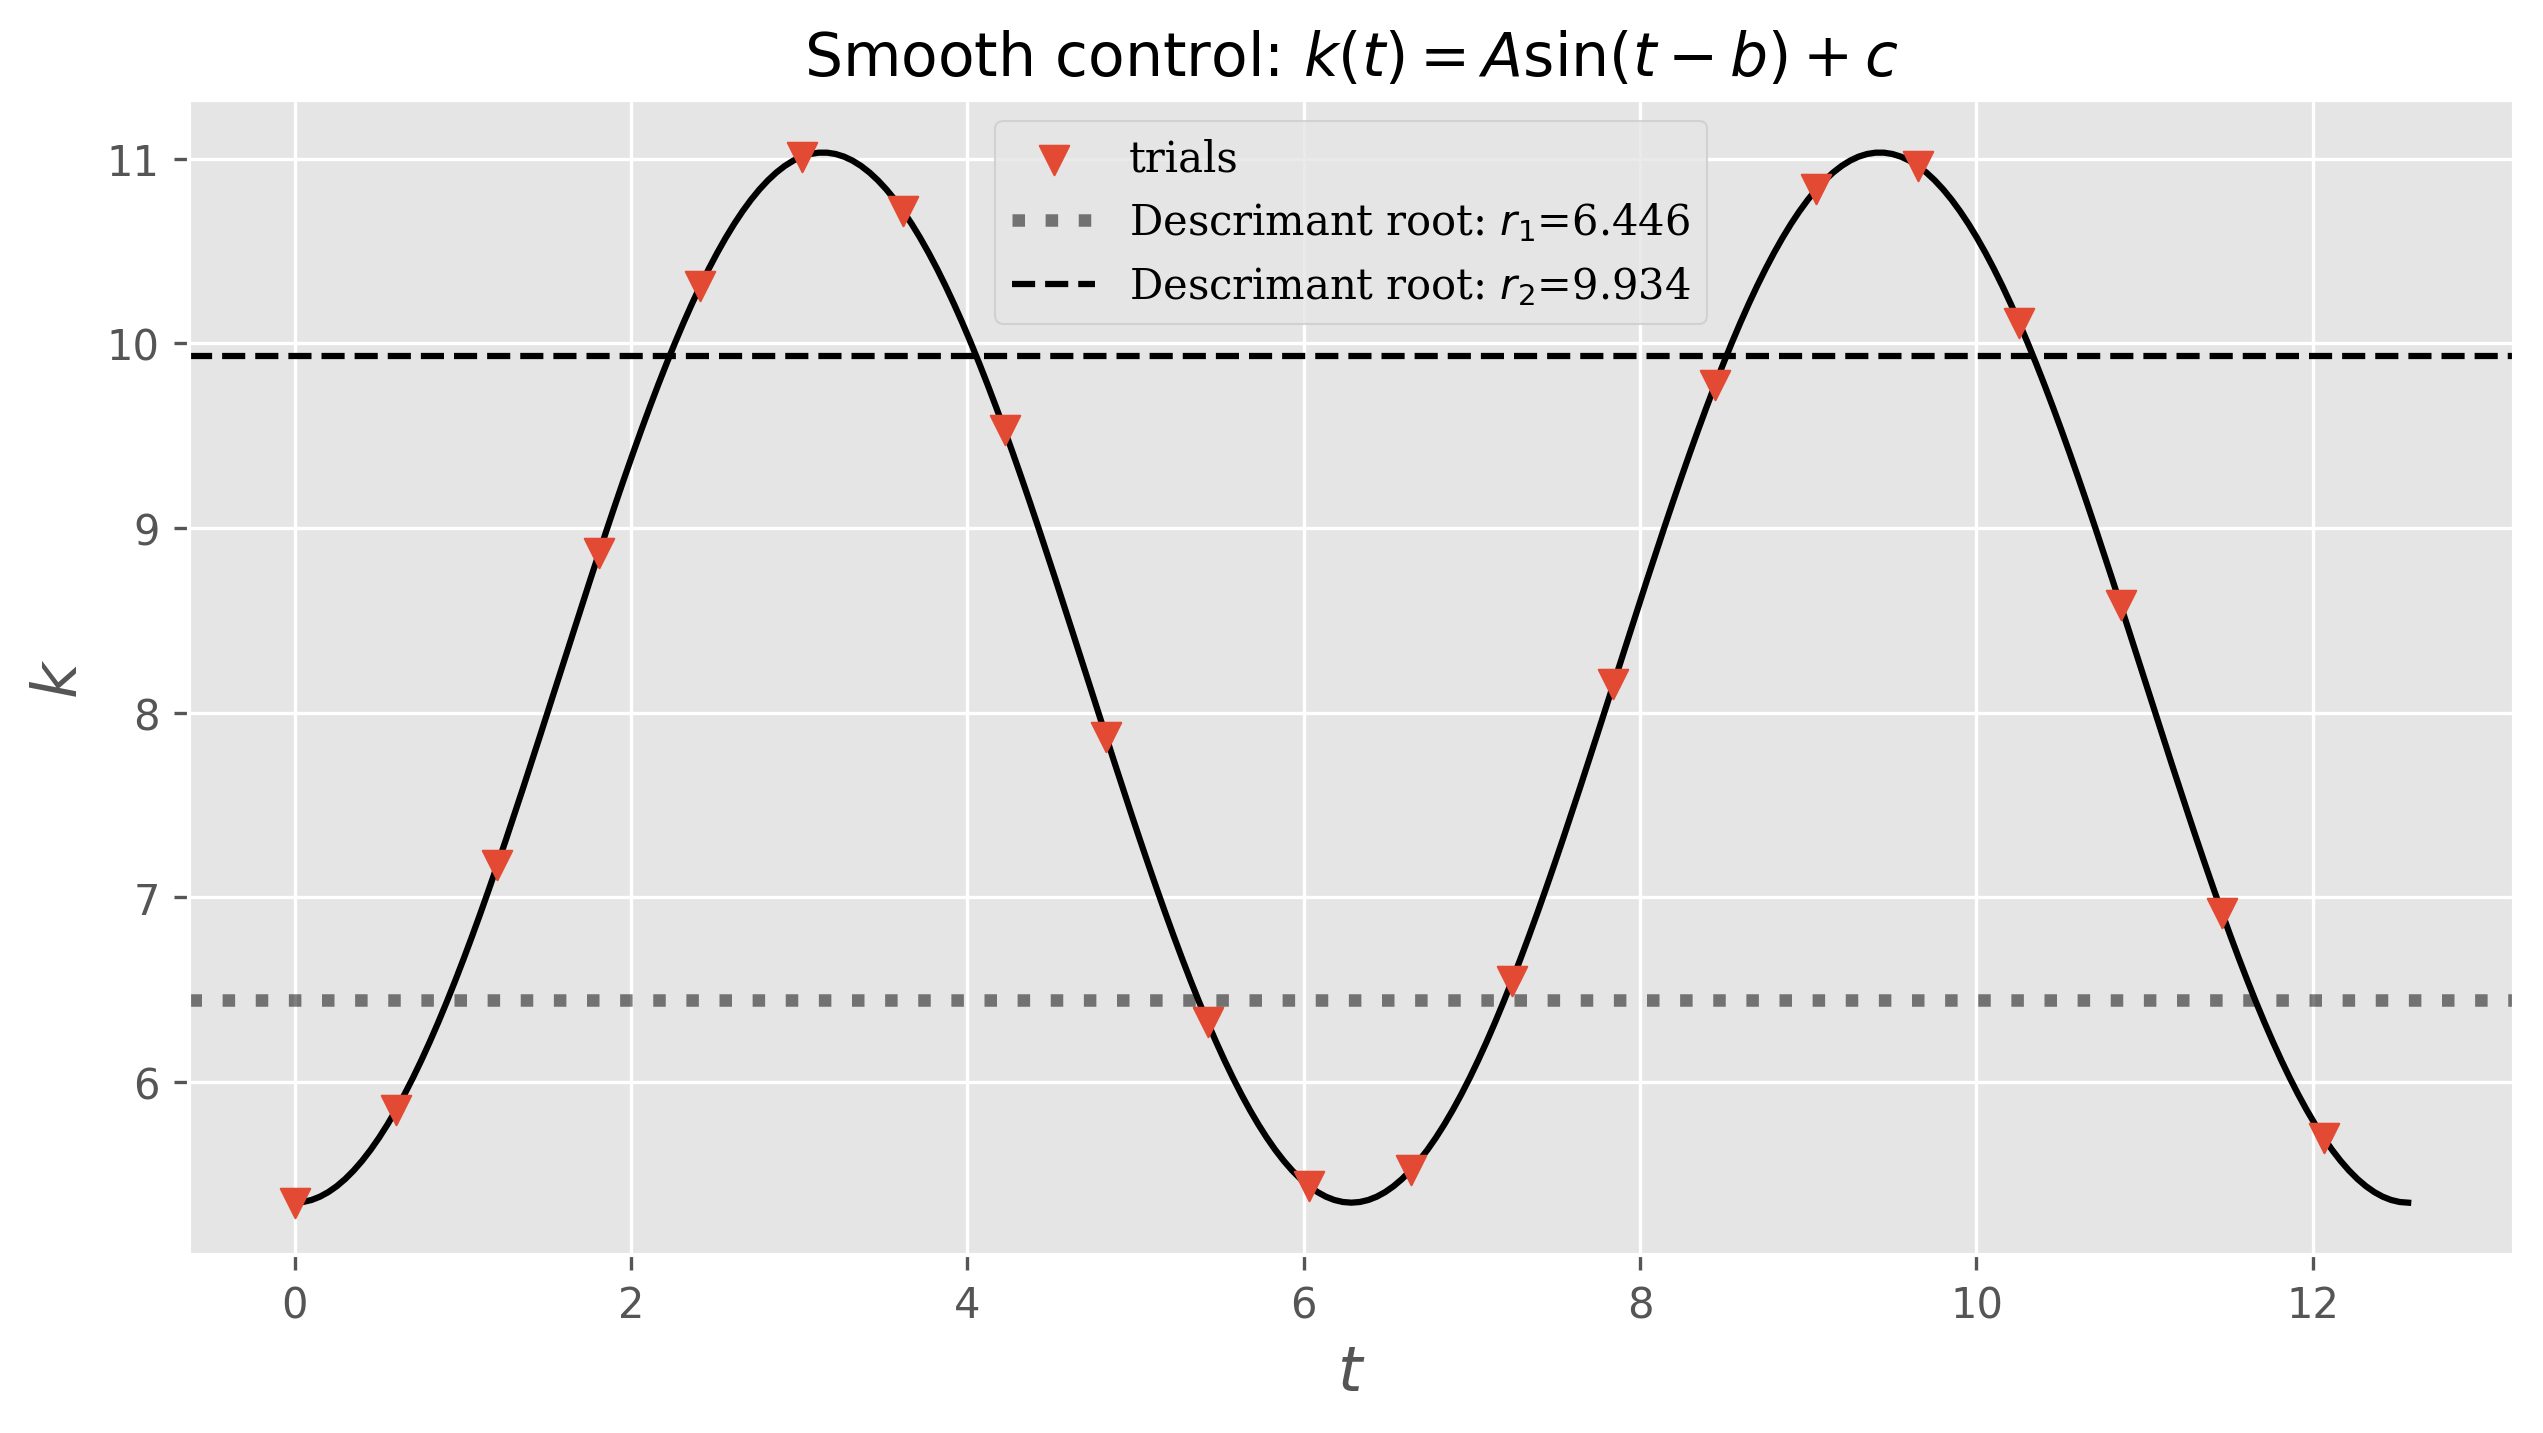

In [3]:
sample_rate = 12
t_span = np.linspace(0,4*np.pi,251)
t_trials = t_span[::sample_rate]
k_true = smooth_k(t_span)
k_trials = smooth_k(t_trials)


fig, ax = plt.subplots(1,1,figsize=(10,5),dpi=300)
t_span = np.linspace(0,4*np.pi,251)

ax.plot(t_span, k_true,c='black',zorder=1)
ax.scatter(
    t_span[::sample_rate],
    k_trials,
    label='trials',
    marker='v',
    s=50,
    zorder=2
)
ax.grid(True)
ax.axhline(r1,linestyle=':',c='black', alpha=0.5,label=rf"Descrimant root: $r_1$={r1:.3f}",lw=3)
ax.axhline(r2, linestyle='--',c='black', label=rf"Descrimant root: $r_2$={r2:.3f}")
ax.set_ylabel(r"$k$", size=15)
ax.set_xlabel(r"$t$",size=15)
ax.set_title(r"Smooth control: $k(t) = A\sin(t-b)+c$")
ax.legend(prop={'family':'serif'})
if savefigs:
    plt.savefig(f"figures/budworm_smooth_control_{len(k_trials)}_trials.pdf")
plt.show()

## Generate trials with control values given above

In [4]:
bw_trials = simulate_trials(
    ks=k_trials,
    x0=1,
    dt=0.2,
    r=0.56,
    eps=1e-4,
    buffer=1e-1,
    t_max=400,
    n_points=701,
    show_progress=True
)
bw_trials

  0%|          | 0/21 [00:00<?, ?it/s]

BudwormTrials contents:
  x_vals: (len=21)
  t_vals: (len=21)
  k_vals: (len=21)
  x_stars: (len=21)
  t_stars: (len=21)
  indices: (len=21)
  dt: 0.2

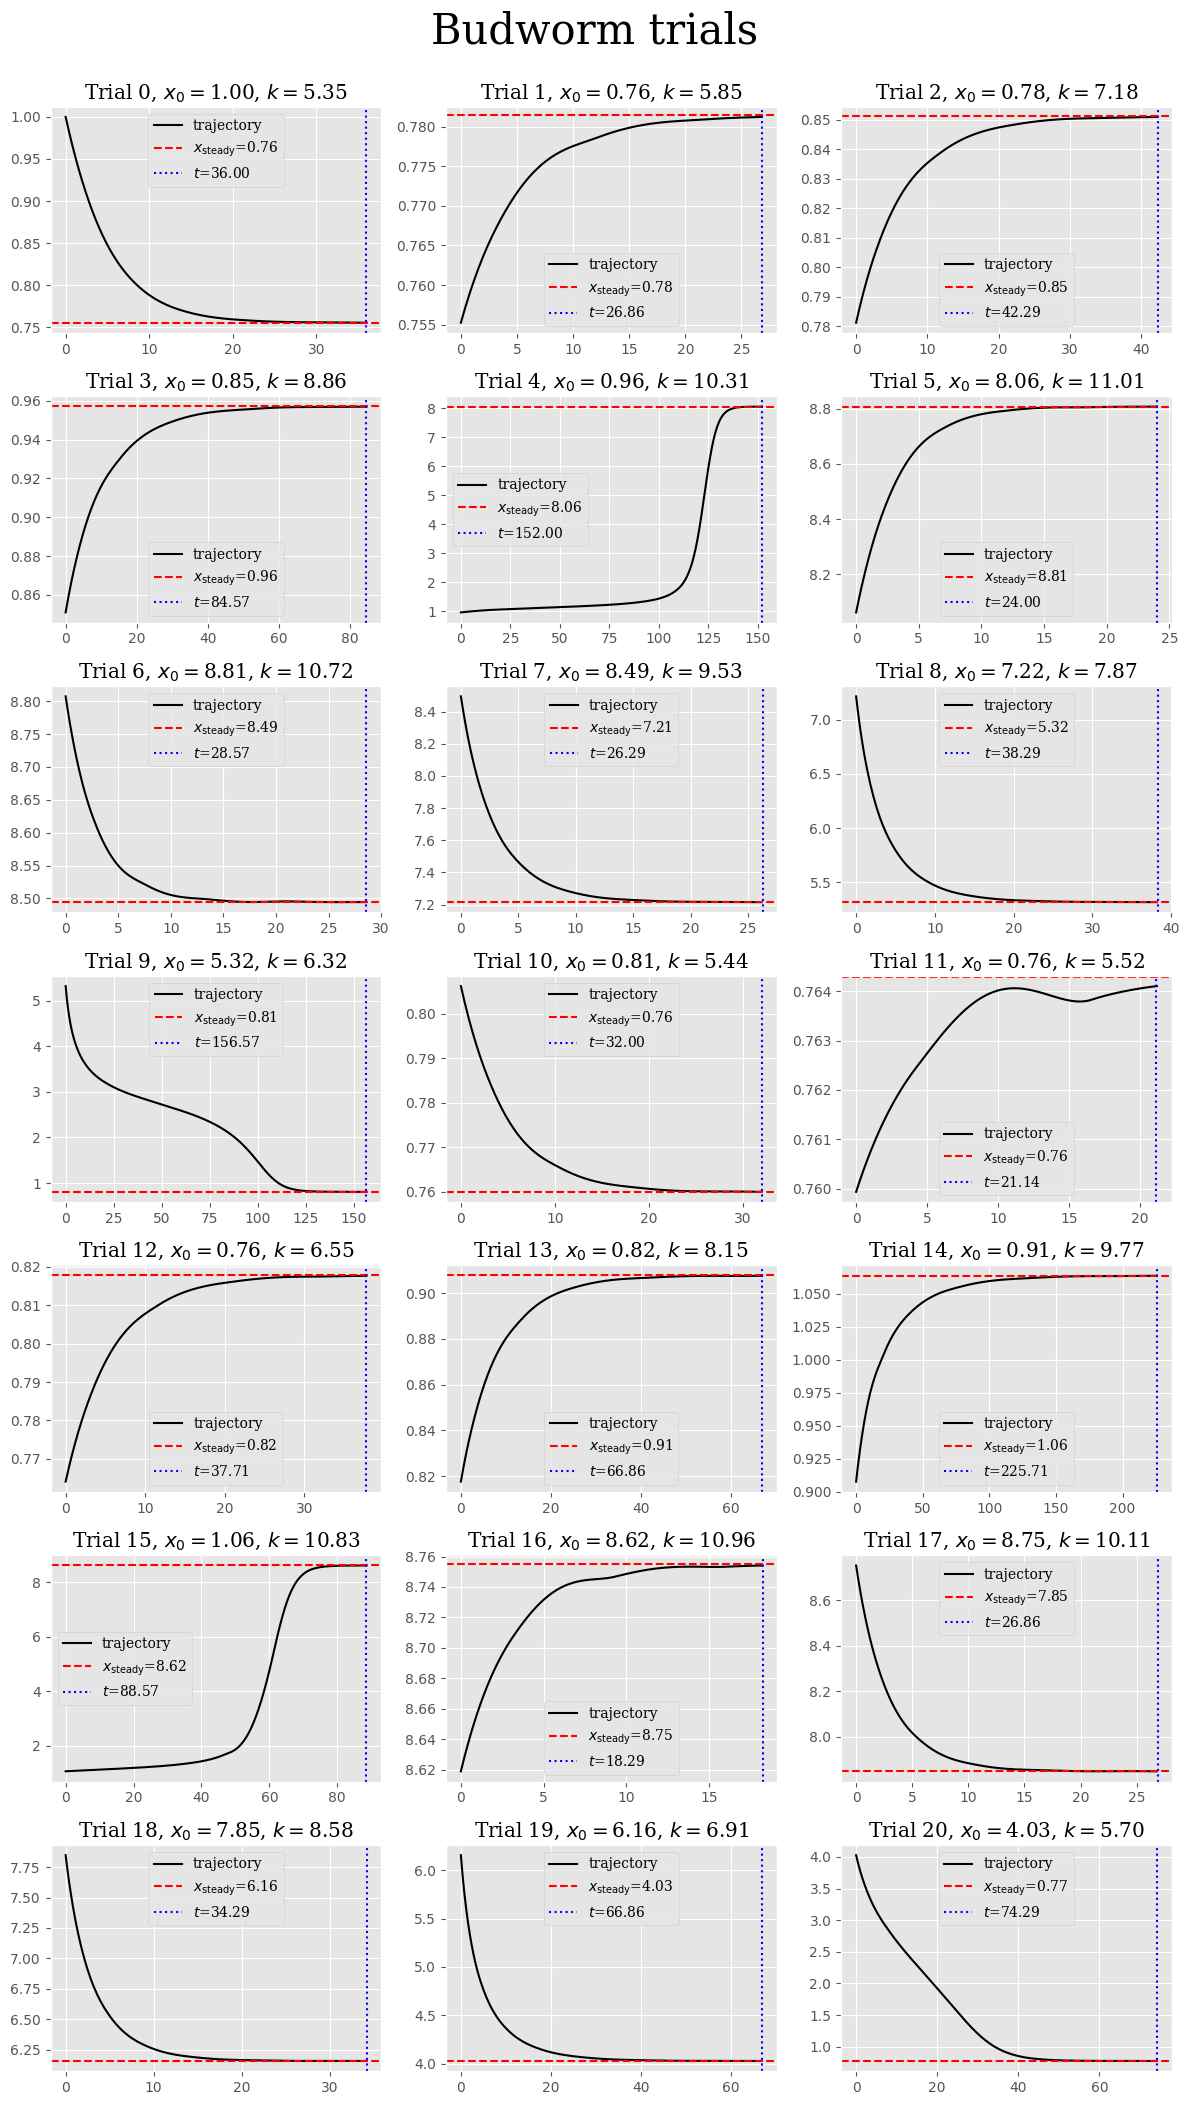

In [5]:
precision = 2
n_plots = len(bw_trials.x_stars)
cols = 3
rows = int(np.ceil(n_plots/cols))

fig, axs = plt.subplots(rows, cols, figsize = (cols*4,rows*3))
axs = axs.flatten()
for idx in range(n_plots):
    x = bw_trials.x_vals[idx]
    t = bw_trials.t_vals[idx]
    xs = bw_trials.x_stars[idx]
    ts = bw_trials.t_stars[idx]

    ax = axs[idx]
    ax.plot(t,x,c='black', label='trajectory')
    ax.axhline(xs,linestyle='--',c='red', label=r"$x_{\text{steady}}$"+f"={xs:.{precision}f}")
    ax.axvline(ts, linestyle=':',c='blue', label=r"$t$="+f"{ts:.{precision}f}")
    ax.legend(prop={'family':'serif'})
    ax.set_title(f"Trial {idx}, "+rf"$x_0=${x[0]:.{precision}f}, " + rf"$k=${k_trials[idx]:.{precision}f}",family='serif')

for idx in range(n_plots,rows*cols):
    fig.delaxes(axs[idx])
fig.suptitle("Budworm trials",family='serif',size=30,y=1.0)
plt.tight_layout()
if savefigs:
    plt.savefig(f"figures/budworm_{len(k_trials)}_trials.pdf")
plt.show()

## Convert to single timeseries

In [139]:
from sklearn.preprocessing import MinMaxScaler

In [141]:
X = np.concatenate(bw_trials.x_vals)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.reshape(-1,1)).reshape(-1)
K = []
for k,x in zip(bw_trials.k_vals,bw_trials.x_vals):
    K.append(np.array([k]*len(x)))

K = np.concatenate(K)

T = np.array([bw_trials.dt*i for i in range(len(X))])

trial_idx = np.cumsum([len(x) for x in bw_trials.x_vals]) -1

In [142]:
X_scaled.shape

(6559,)

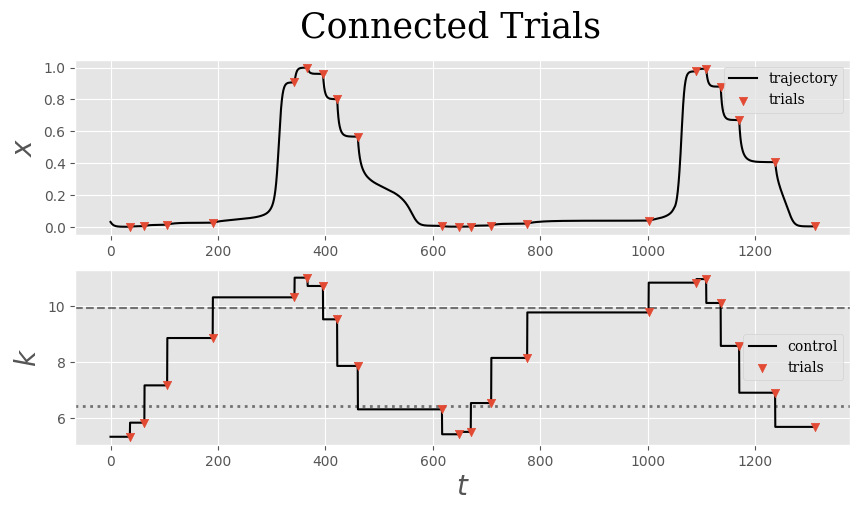

In [143]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,5))
ax1.plot(T,X_scaled,c='black', label='trajectory')
ax1.set_ylabel(r"$x$",size=20)
ax1.scatter(T[trial_idx], X_scaled[trial_idx],marker='v', zorder=2,label='trials')
ax1.legend(prop={'family':'serif'})

ax2.plot(T,K,c='black',label='control')
ax2.scatter(T[trial_idx], K[trial_idx],marker='v', zorder=2, label='trials')
ax2.set_ylabel(r"$k$",size=20)
ax2.set_xlabel(r"$t$",size=20,family='serif')

ax2.legend(prop={'family':'serif'})

ax2.axhline(r1,linestyle=':',c='black', alpha=0.5,label=rf"Descrimant root: $r_1$={r1:.3f}",lw=2,zorder=1)
ax2.axhline(r2, linestyle='--',c='black', alpha=0.5,label=rf"Descrimant root: $r_2$={r2:.3f}",zorder=1)



fig.suptitle("Connected Trials", size=25, family='serif')
if savefigs:
    plt.savefig(f"figures/budworm_connected_{len(k_trials)}_trials.pdf")
plt.show()

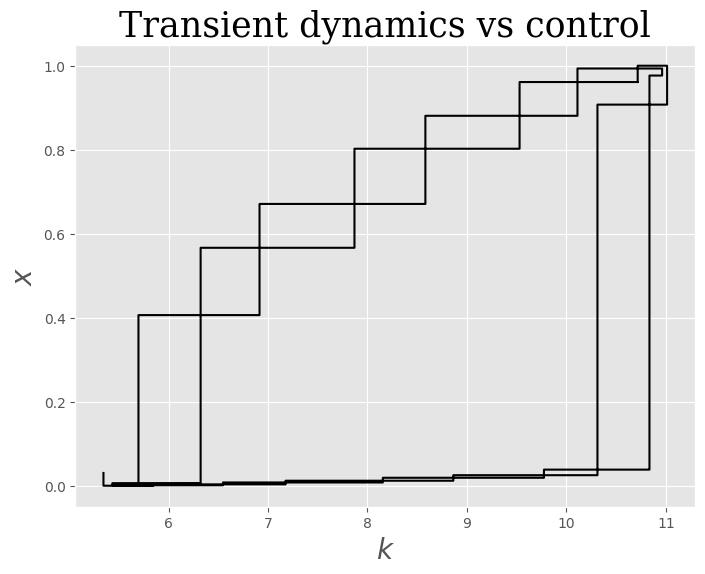

In [144]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(K,X_scaled,c='black')
ax.set_xlabel(r"$k$",size=20)
ax.set_ylabel(r"$x$",size=20)
ax.set_title("Transient dynamics vs control", family='serif', size=25)
if savefigs:
    plt.savefig(f"figures/transient_vs_control_{len(k_trials)}_trials.pdf")
plt.show()

# Try model learning on data

## Full data results

In [196]:
from stabnode.data import TrajectoryDataset
from stabnode.utils import set_global_seed, _load_loop_wrapper
from stabnode.node import Felu, Gelu, StabNODE
from data.budworm import g_true
from torchode import solve_ivp
import torch
import torch.nn as nn
import time

seed = 1234
set_global_seed(seed=seed)

In [146]:
dtype = torch.float32

X = torch.tensor(X_scaled.reshape(1,-1),dtype=dtype,device='cpu')
T = torch.tensor(T, dtype=dtype, device='cpu')

In [147]:
f = Felu(1,1,4)
g = Gelu(2,1,4)

model = StabNODE(f,g).to('cpu')

In [148]:

train_dataset = TrajectoryDataset(X.T, T, window_size=None)

In [149]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
)

In [52]:
def control_func(t):
    return torch.tensor(smooth_k_torch(t),dtype=torch.float32,device='cpu').unsqueeze(0)

In [151]:
# control_func(Ti[0]) ,x0i.shape
# control_func(Ti[0]).dtype

In [ ]:
for a,b,c in train_loader:
    print(a.shape,b.shape,c.shape)

torch.float32 torch.Size([1, 6559]) torch.Size([1, 1])


In [ ]:
n_epochs = 10
lr = 1e-1
show_progress = True
solve_method = 'dopri5'
solve_method = 'tsit5'
loss_criteria = nn.MSELoss()
# control_func = smooth_k
opt = torch.optim.Adam(list(f.parameters())+list(g.parameters()), lr = lr)


loop_wrapper = _load_loop_wrapper(show_progress)
loop_wrapper2 = _load_loop_wrapper(True)

model.train()
losses = []
times = []
status = []

Xi_epoch_predictions = []
Tis_epoch = []
for epoch in loop_wrapper(range(n_epochs)):
    t1 = time.time()
    epoch_loss = 0.0
    num_batches = 0
    epoch_losses = []

    Xi_predictions = []
    Tis = []
    for Xi, Ti, x0i in loop_wrapper2(train_loader):
        Xi = Xi.squeeze() # [batch, time, dim]
        Ti = Ti.squeeze()

        if not x0i.requires_grad:
            x0i = x0i.clone().detach().requires_grad_()


        opt.zero_grad()

        sol = solve_ivp(
            f=lambda t, x: model(t, x, control_func),
            y0=x0i,
            t_eval=Ti,
            method=solve_method
        )

        status.append(sol.status)
        Xi_pred = sol.ys.squeeze()
        Xi_predictions.append(Xi_pred)
        Tis.append(Ti)
        loss = loss_criteria(Xi_pred, Xi)

        loss.backward()
        opt.step()
        epoch_losses.append(loss.item())
        epoch_loss += loss.item()
        num_batches += 1

    Xi_epoch_predictions.append(Xi_predictions)
    Tis_epoch.append(Tis)
    avg_loss = epoch_loss / num_batches
    print(f"Epoch {epoch}: Loss: {avg_loss}")
    losses.append(avg_loss)

    t2 = time.time()
    times.append(t2 - t1)

    # if avg_loss < 0.01:
    #     break

    

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

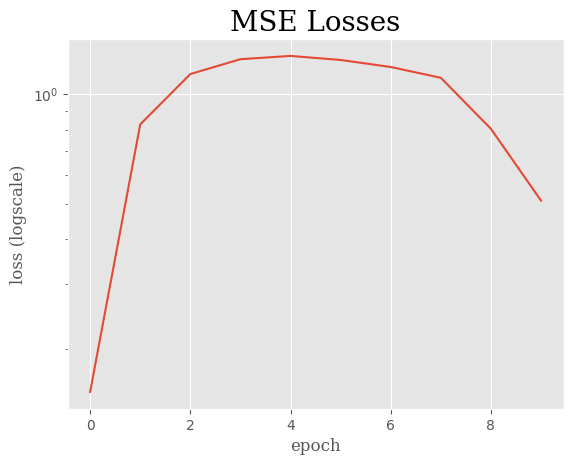

[tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0])]

In [235]:
plt.plot(losses)
plt.ylabel("loss (logscale)", family='serif')
plt.xlabel("epoch", family='serif')
plt.yscale('log')

plt.title("MSE Losses",size=20, family='serif')

plt.show()
status

In [181]:
X_scaled.dtype
Xi.dtype

torch.float32

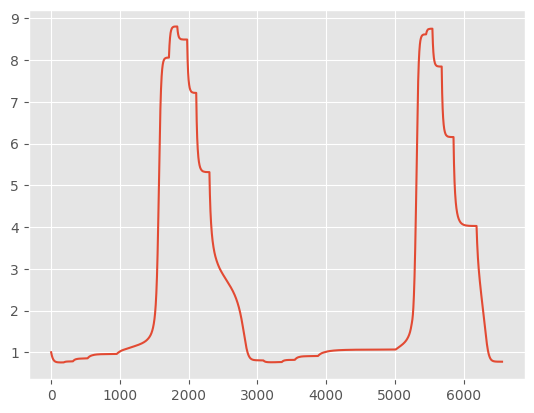

In [204]:
X = np.concatenate(bw_trials.x_vals)
plt.plot(X)

In [205]:
g = model.g

g.eval()

g_pred = []
g_true_arr = []

for (ki,xi,xi_unscaled) in zip(K,X_scaled,X):
    g_true_arr.append(g_true(xi_unscaled,ki,r=0.56))
    xi = torch.tensor([xi],dtype=torch.float32,device='cpu').reshape(-1,1)
    ki = torch.tensor([ki],dtype=torch.float32,device='cpu').reshape(-1,1)

    with torch.no_grad():
        g_pred.append(g(xi,ki).detach().cpu().numpy())

g_true_arr = np.array(g_true_arr)
g_pred = np.array(g_pred).reshape(-1)

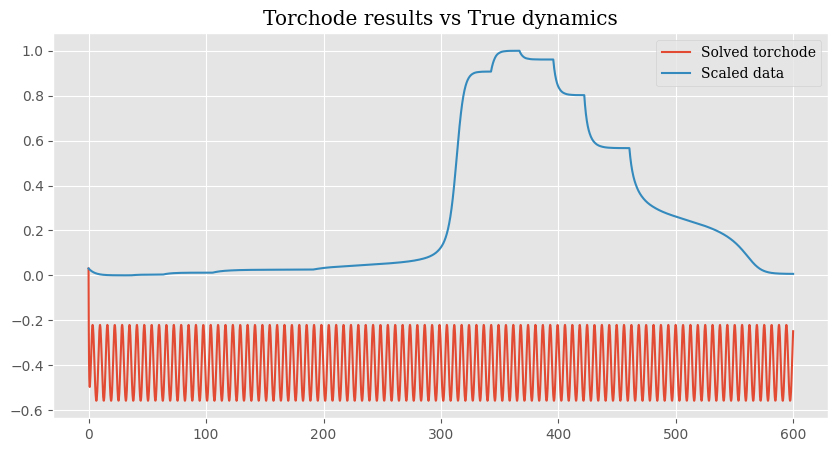

In [244]:
out = sol.ys.detach().numpy().reshape(-1)
cutoff  = 3000

fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(T[:cutoff],out[:cutoff], label="Solved torchode")
ax.plot(T[:cutoff],X_scaled[:cutoff], label="Scaled data")
ax.set_title("Torchode results vs True dynamics", family='serif')
ax.legend(prop={'family':'serif'})
plt.show()

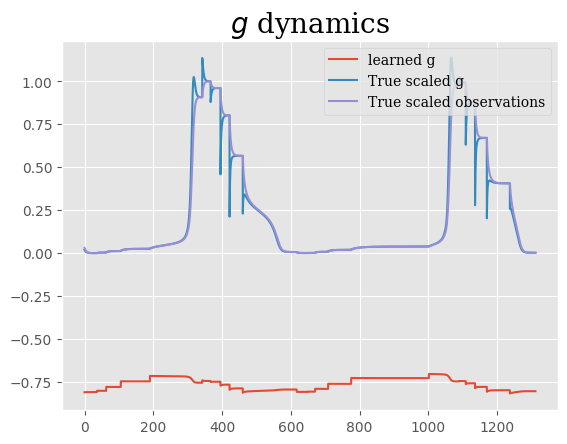

In [246]:
plt.title(r"$g$ dynamics", family='serif', size=20)
plt.plot(T,g_pred, label="learned g")
plt.plot(T,scaler.transform(g_true_arr.reshape(-1,1)).reshape(-1), label="True scaled g")
# plt.plot(T,X)
plt.plot(T,X_scaled, label='True scaled observations')
plt.legend(prop={'family':'serif'})
plt.show()


In [268]:
# plot g by fixed k values 
x_linspace = np.linspace(-1,10,201)
x_scaled = scaler.transform(x_linspace.reshape(-1,1)).reshape(-1)

g_true_trials = []
g_pred_trials = []

for ki in k_trials:
    g_true_trials.append(scaler.transform(g_true(x_linspace,ki,r=0.56).reshape(-1,1)).reshape(-1))

    g_pred_i = []
    with torch.no_grad():
        for xi in x_scaled:
            xi = torch.tensor([xi],dtype=torch.float32,device='cpu').reshape(-1,1)
            ki = torch.tensor([ki],dtype=torch.float32,device='cpu').reshape(-1,1)
            g_pred_i.append(g(xi,ki).detach().cpu().numpy())
    g_pred_trials.append(np.array(g_pred_i).reshape(-1))
            

        


In [270]:
len(k_trials)

21

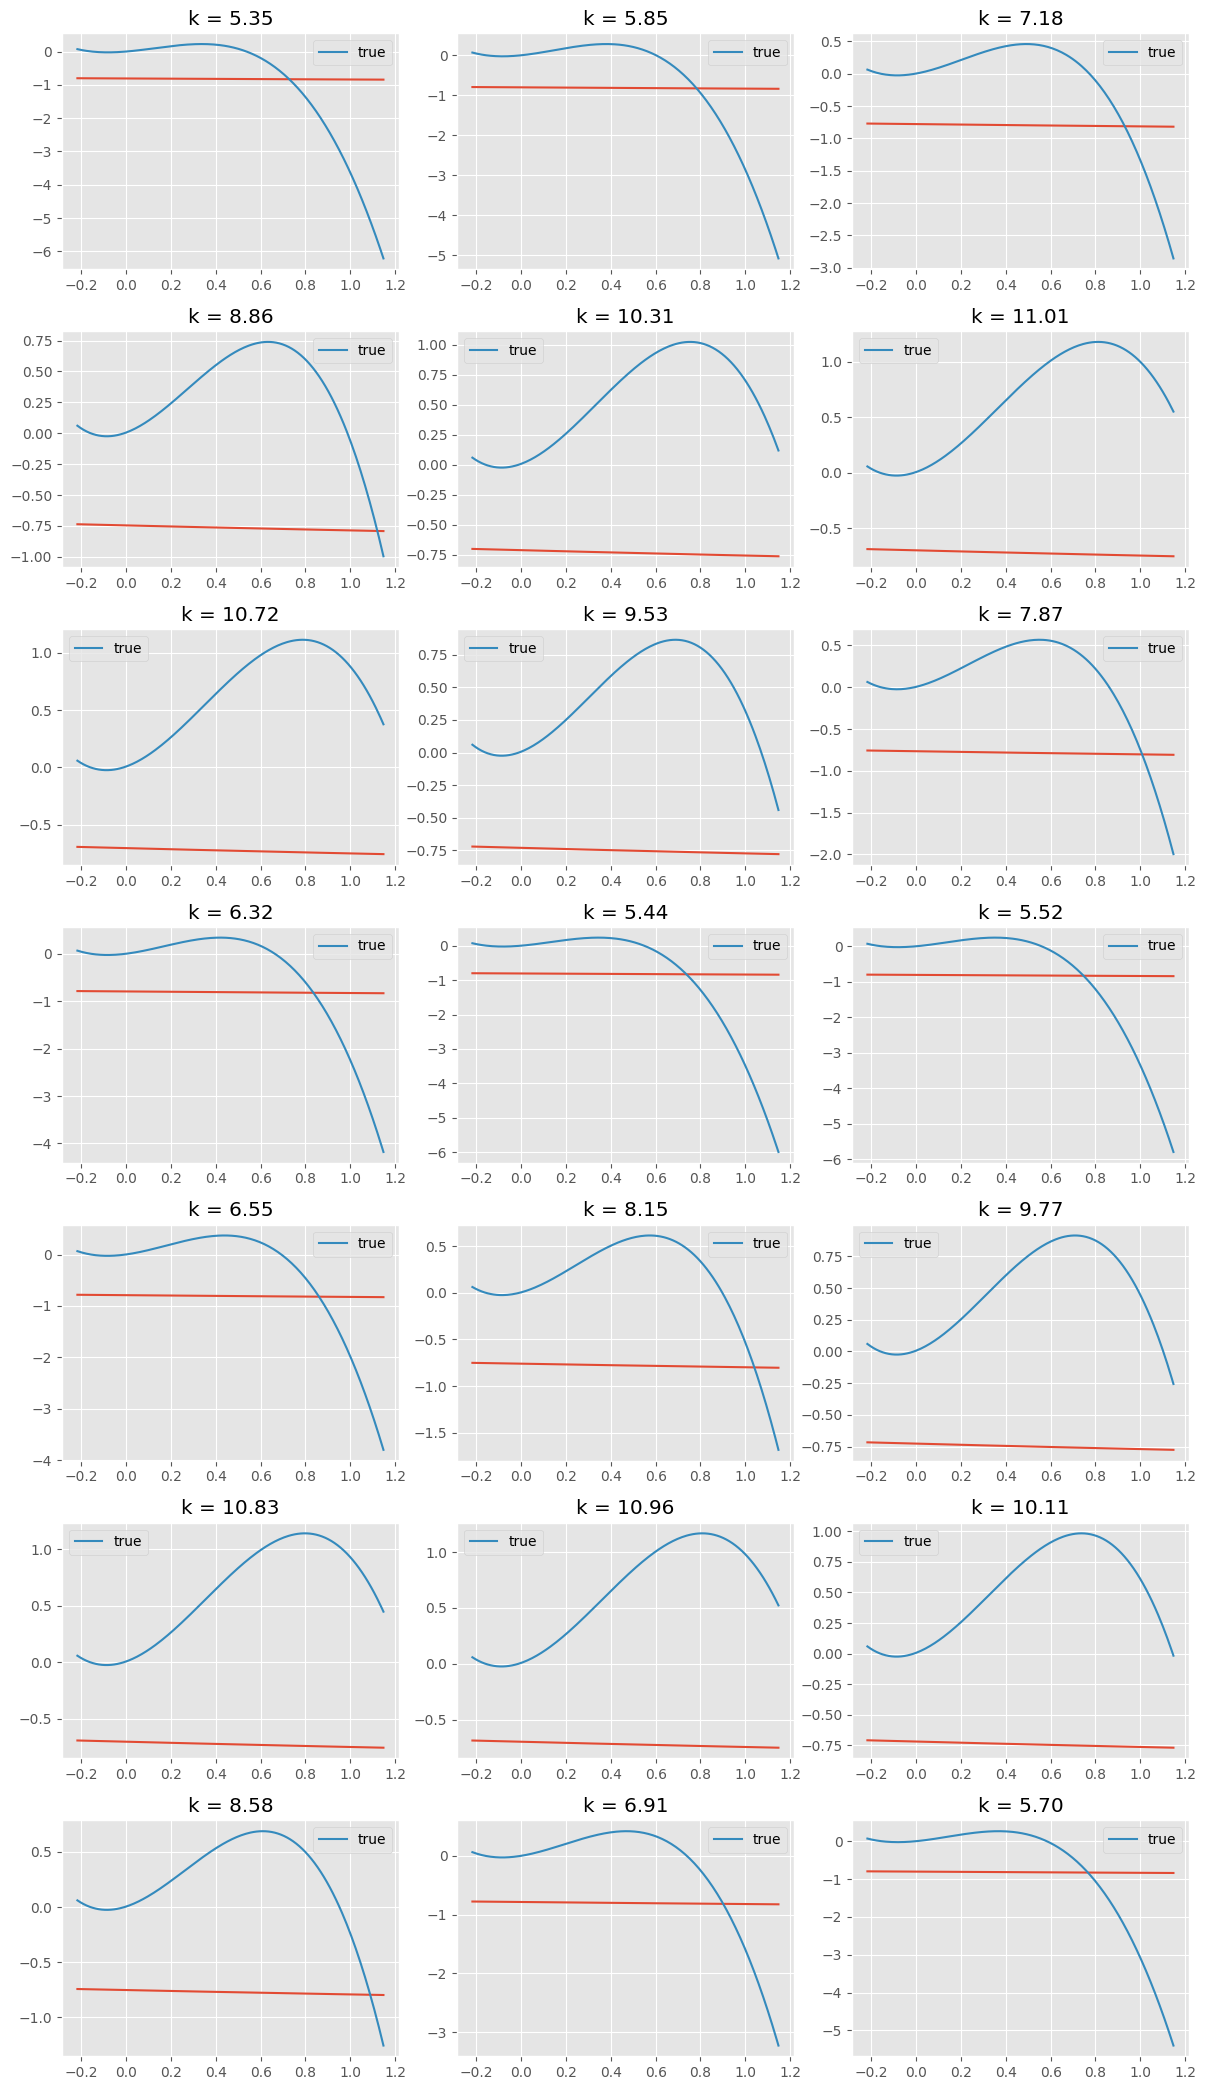

In [ ]:
precision = 2
n_plots = len(k_trials)
cols = 3
rows = int(np.ceil(n_plots/cols))

fig, axs = plt.subplots(rows, cols, figsize = (cols*4,rows*3))
axs = axs.flatten()

for true, pred,ki,ax in zip(g_true_trials, g_pred_trials,k_trials,axs):
    ax.set_title(f"k = {ki:.{precision}f}")
    ax.plot(x_scaled,pred)
    ax.plot(x_scaled,true, label='true')
    ax.legend()
plt.tight_layout()
plt.show()

In [252]:
scaler.data_min_

array([0.75525723])

# Learn by trials

In [76]:
import torch
import torch.nn as nn
from stabnode.node import Felu, Gelu, StabNODE
from stabnode.utils import set_global_seed, _load_loop_wrapper
from sklearn.preprocessing import MinMaxScaler
from torchode import solve_ivp


In [77]:


X = np.concatenate(bw_trials.x_vals)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.reshape(-1,1)).reshape(-1)
K = []
for k,x in zip(bw_trials.k_vals,bw_trials.x_vals):
    K.append(np.array([k]*len(x)))

K = np.concatenate(K)

T = np.array([bw_trials.dt*i for i in range(len(X))])

trial_idx = np.concatenate(([0],np.cumsum([len(x) for x in bw_trials.x_vals])))

In [78]:

x_vals_scaled = [
    torch.tensor(X_scaled[trial_idx[i]:trial_idx[i+1]],dtype=torch.float32,device='cpu')
    for i in range(len(trial_idx)-1)
]

T_cum = [
    torch.tensor(T[trial_idx[i]:trial_idx[i+1]],dtype=torch.float32, device='cpu')
     for i in range(len(trial_idx)-1)
]

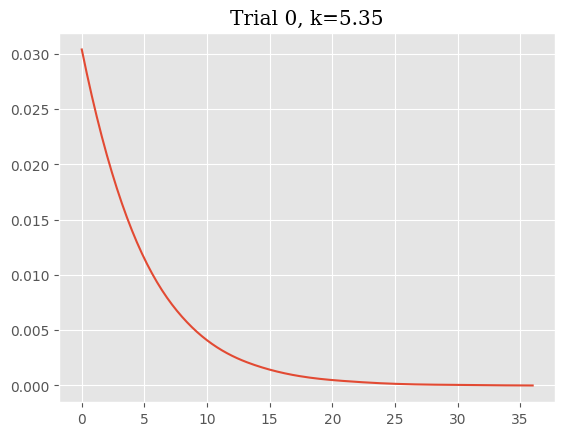

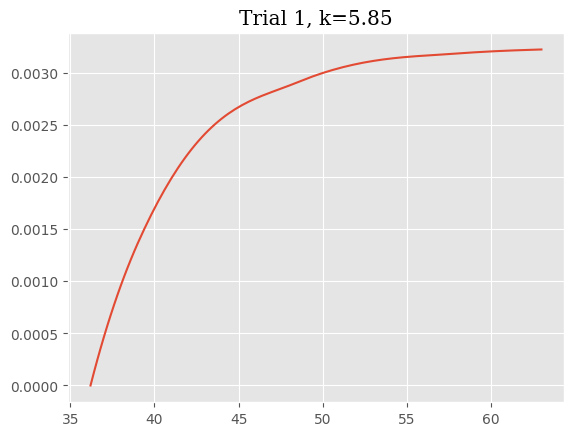

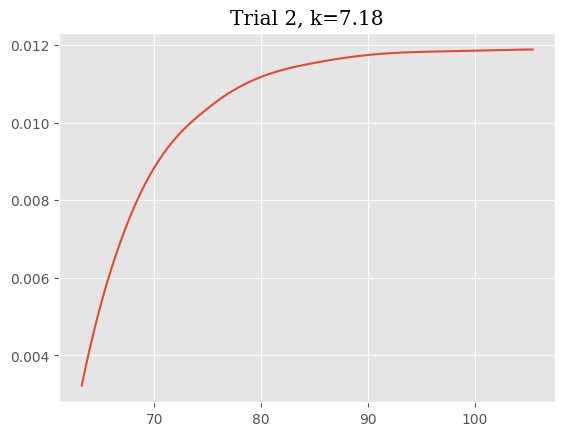

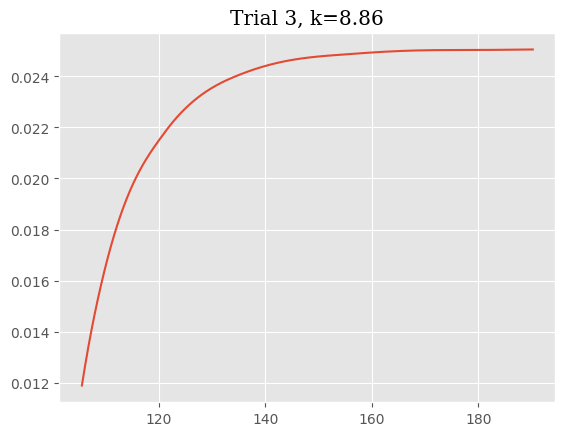

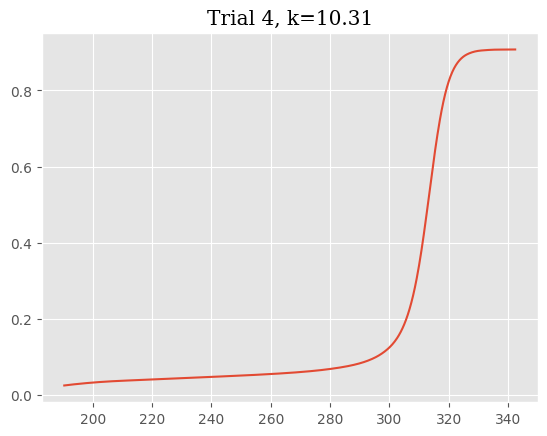

In [79]:

for idx, (ti , xi) in enumerate(zip(T_cum, x_vals_scaled)):
    if idx < 5:
        ki = bw_trials.k_vals[idx]
        plt.title(f"Trial {idx}, k={ki:.2f}", family='serif')
        plt.plot(ti,xi)
        plt.show()

In [80]:
class TrialsDataset(torch.utils.data.Dataset):
    def __init__(self, x_trials, t_trials,):
        self.x_trials = x_trials             # shape [T_total, d]
        self.t_trials = t_trials              # shape [T_total]

    def __len__(self):
        return len(self.x_trials) 

    def __getitem__(self, idx):
        if idx < 0 or idx >= self.__len__():
            raise IndexError(
                f"Index {idx} is out of bounds of dataset size: {self.__len__()}."
            )
        
        
        Xi = self.x_trials[idx]                                          
        ti = self.t_trials[idx]  
        x0 = Xi[0]           

        return Xi,ti,x0

In [81]:
dataset = TrialsDataset(x_vals_scaled, T_cum)

In [82]:
train_loader = torch.utils.data.DataLoader(dataset,batch_size=1,shuffle=True,num_workers=0)


In [83]:
for a,b,c in train_loader:
    print(c.reshape(-1,1))

tensor([[0.0011]])
tensor([[0.0032]])
tensor([[0.]])
tensor([[0.0251]])
tensor([[0.0189]])
tensor([[1.]])
tensor([[0.0119]])
tensor([[0.9934]])
tensor([[0.9766]])
tensor([[0.8023]])
tensor([[0.5665]])
tensor([[0.0383]])
tensor([[0.0006]])
tensor([[0.9074]])
tensor([[0.9611]])
tensor([[0.0304]])
tensor([[0.0077]])
tensor([[0.8808]])
tensor([[0.0063]])
tensor([[0.4062]])
tensor([[0.6709]])


In [84]:


f = Felu(1,1,4)
g = Gelu(2,1,4)

model = StabNODE(f,g).to('cpu')

In [85]:
n_epochs = 30
lr = 1e-2
show_progress = True
solve_method = 'dopri5'
solve_method = 'tsit5'
loss_criteria = nn.MSELoss()
# control_func = smooth_k
opt = torch.optim.Adam(list(f.parameters())+list(g.parameters()), lr = lr)


loop_wrapper = _load_loop_wrapper(show_progress)
loop_wrapper2 = _load_loop_wrapper(True)

model.train()
losses = []
times = []
status = []

Xi_epoch_predictions = []
Tis_epoch = []
for epoch in loop_wrapper(range(n_epochs)):
    t1 = time.time()
    epoch_loss = 0.0
    num_batches = 0
    epoch_losses = []

    Xi_predictions = []
    Tis = []
    for Xi, Ti, x0i in loop_wrapper2(train_loader):
        Xi = Xi.squeeze() # [batch, time, dim]
        Ti = Ti.squeeze()
        x0i = x0i.reshape(-1,1)

        if not x0i.requires_grad:
            x0i = x0i.clone().detach().requires_grad_()


        opt.zero_grad()

        sol = solve_ivp(
            f=lambda t, x: model(t, x, control_func),
            y0=x0i,
            t_eval=Ti,
            method=solve_method
        )

        status.append(sol.status)
        Xi_pred = sol.ys.squeeze()
        Xi_predictions.append(Xi_pred)
        Tis.append(Ti)
        loss = loss_criteria(Xi_pred, Xi)

        loss.backward()
        opt.step()
        epoch_losses.append(loss.item())
        epoch_loss += loss.item()
        num_batches += 1

    Xi_epoch_predictions.append(Xi_predictions)
    Tis_epoch.append(Tis)
    avg_loss = epoch_loss / num_batches
    print(f"Epoch {epoch}: Loss: {avg_loss}")
    losses.append(avg_loss)

    t2 = time.time()
    times.append(t2 - t1)    

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 0: Loss: 0.333628860978587


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1: Loss: 0.3007033908562291


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 2: Loss: 0.2880420313837628


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 3: Loss: 0.3738655434877035


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 4: Loss: 0.36734415472130333


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 5: Loss: 0.35617043988202657


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 6: Loss: 0.3454949410987042


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 7: Loss: 0.3420865088257761


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 8: Loss: 0.33987361398924676


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 9: Loss: 0.3380317841656506


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 10: Loss: 0.3348587400257765


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 11: Loss: 0.32128784439659547


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 12: Loss: 0.3112691585639758


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 13: Loss: 0.30748186890213264


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 14: Loss: 0.30656491714485345


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 15: Loss: 0.31709362706169486


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 16: Loss: 0.318587485079964


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 17: Loss: 0.3179721933944772


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 18: Loss: 0.3167947879327195


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 19: Loss: 0.31614270841791514


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 20: Loss: 0.3149004534685186


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 21: Loss: 0.3134727881711331


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 22: Loss: 0.3117714491118455


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 23: Loss: 0.3093303916088882


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 24: Loss: 0.3069620950790566


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 25: Loss: 0.3054243470320389


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 26: Loss: 0.3040517300722145


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 27: Loss: 0.30384268755802796


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 28: Loss: 0.30265106112208395


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 29: Loss: 0.3005082846308748


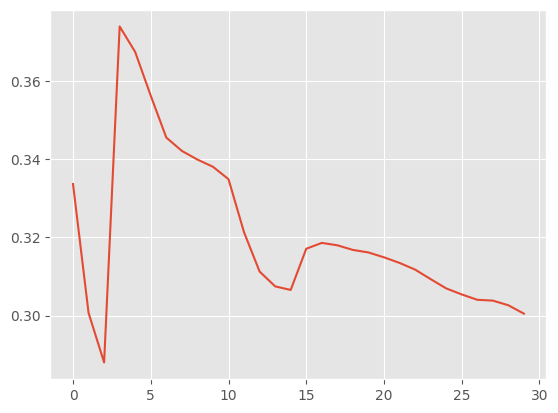

In [86]:
plt.plot(losses)
# plt.yscale('log')

In [87]:
from data.budworm import g_true

g_learn = model.g
g_learn.eval()

# plot g by fixed k values 
x_linspace = np.linspace(-1,10,201)
x_scaled = scaler.transform(x_linspace.reshape(-1,1)).reshape(-1)

g_true_trials = []
g_pred_trials = []

for ki in k_trials:
    g_true_trials.append(scaler.transform(g_true(x_linspace,ki,r=0.56).reshape(-1,1)).reshape(-1))

    g_pred_i = []
    with torch.no_grad():
        for xi in x_scaled:
            xi = torch.tensor([xi],dtype=torch.float32,device='cpu').reshape(-1,1)
            ki = torch.tensor([ki],dtype=torch.float32,device='cpu').reshape(-1,1)
            g_pred_i.append(g_learn(xi,ki).detach().cpu().numpy())
    g_pred_trials.append(np.array(g_pred_i).reshape(-1))

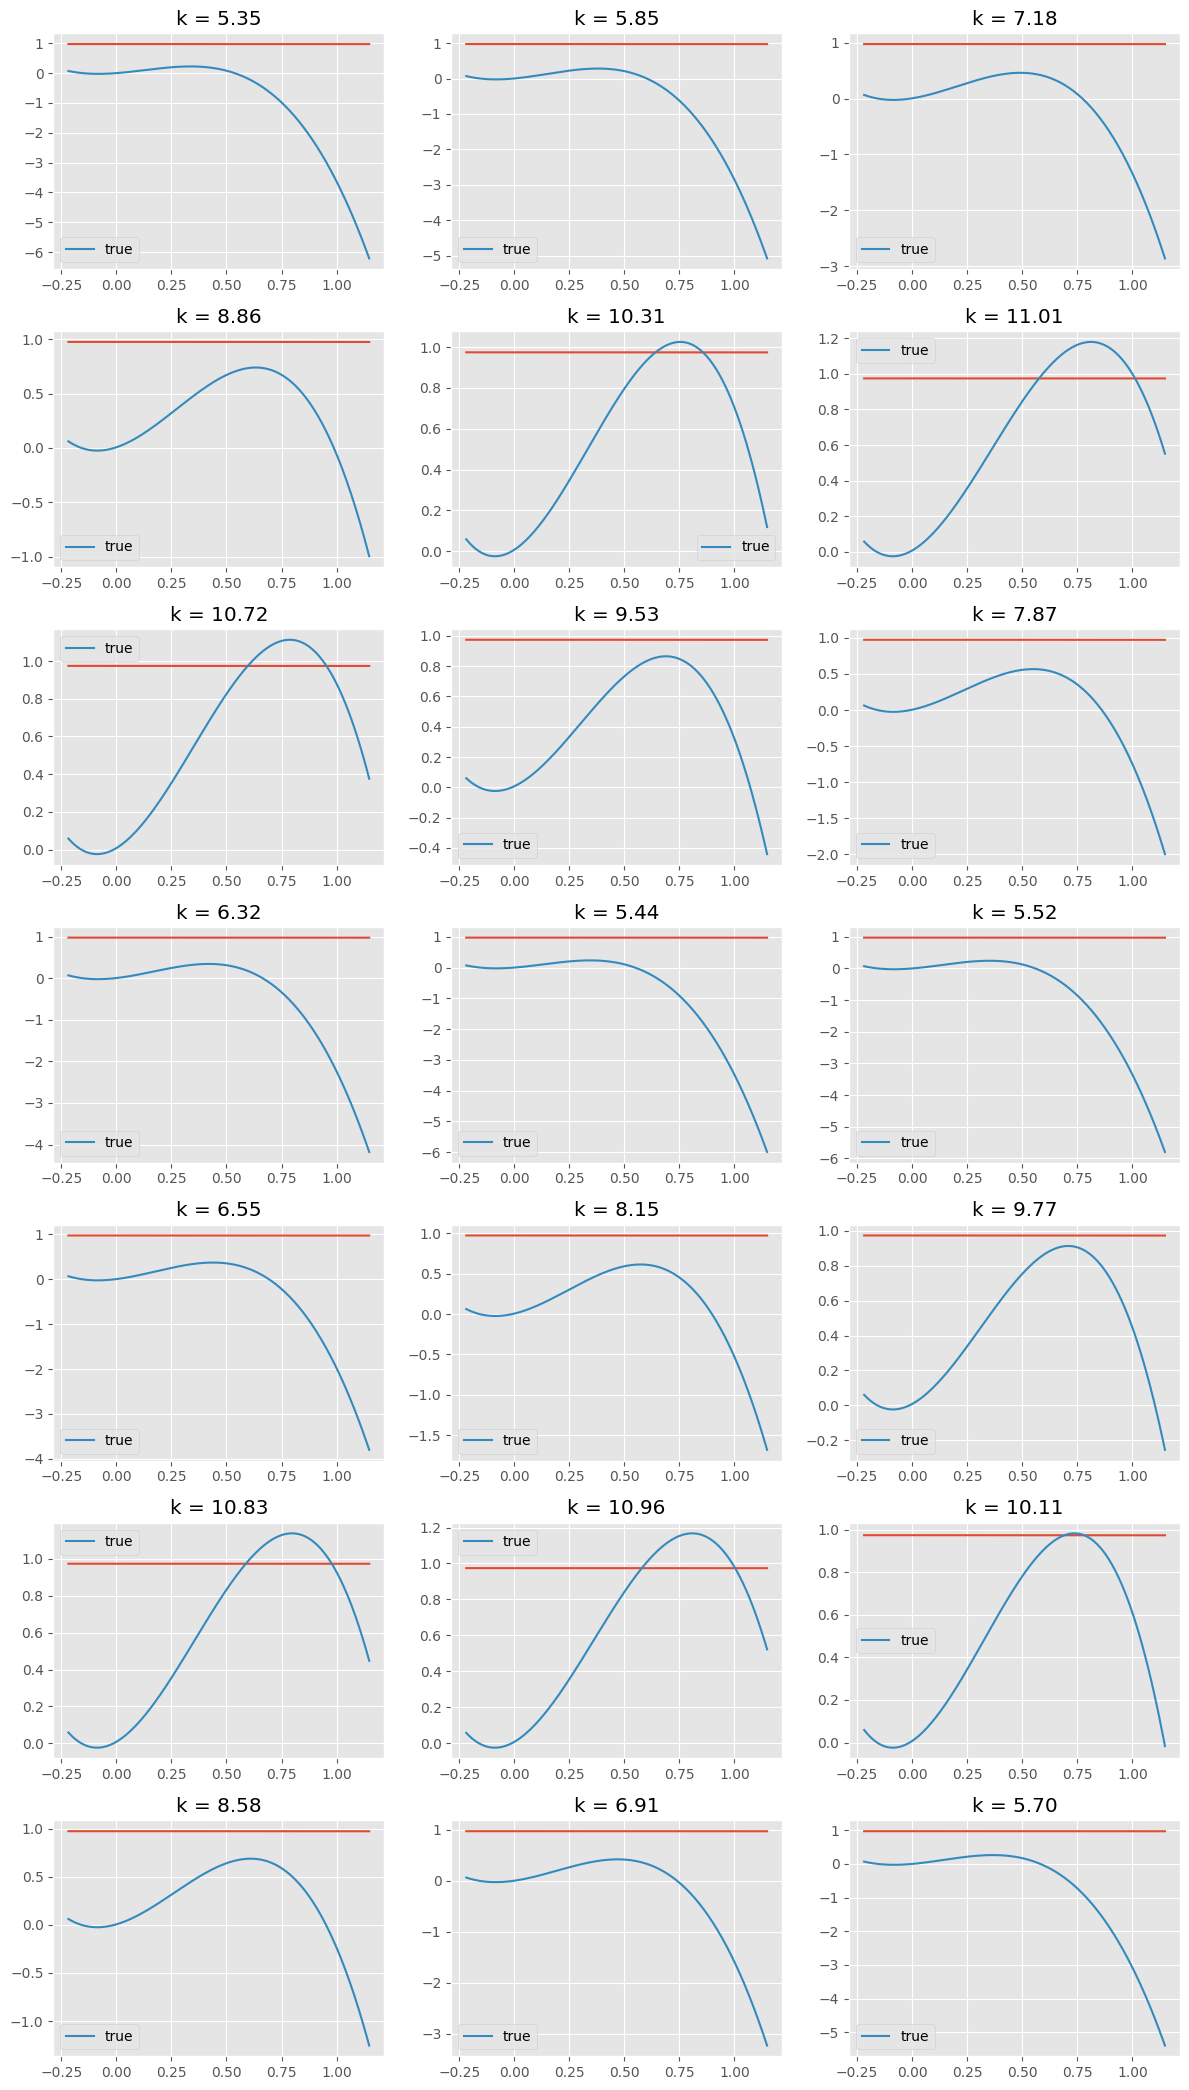

In [66]:
precision = 2
n_plots = len(k_trials)
cols = 3
rows = int(np.ceil(n_plots/cols))

fig, axs = plt.subplots(rows, cols, figsize = (cols*4,rows*3))
axs = axs.flatten()

for true, pred,ki,ax in zip(g_true_trials, g_pred_trials,k_trials,axs):
    ax.set_title(f"k = {ki:.{precision}f}")
    ax.plot(x_scaled,pred)
    ax.plot(x_scaled,true, label='true')
    ax.legend()
plt.tight_layout()
plt.show()

# look at learned model


In [67]:
g_learn = model.g
f_learn = model.f

g_learn.eval()
f_learn.eval()

model_eval = StabNODE(f_learn, g_learn)

In [68]:
new_loader = torch.utils.data.DataLoader(dataset,shuffle=False)

  0%|          | 0/21 [00:00<?, ?it/s]

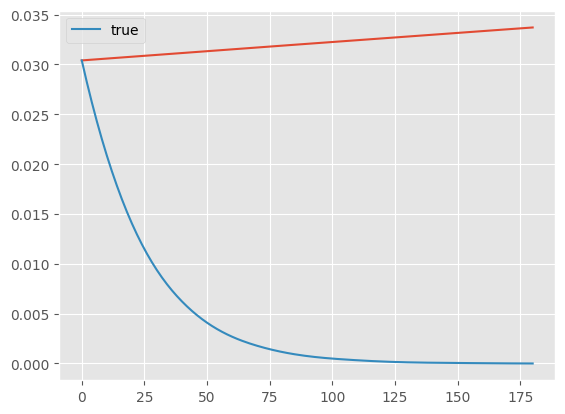

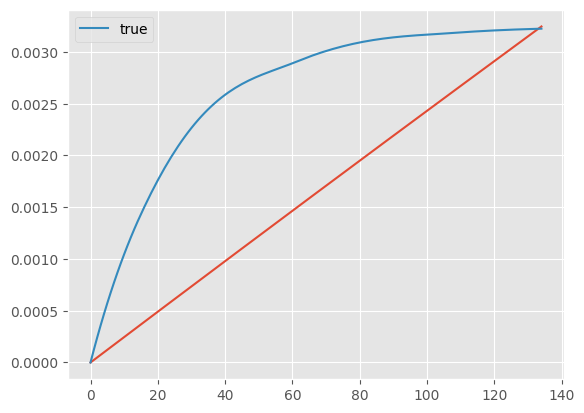

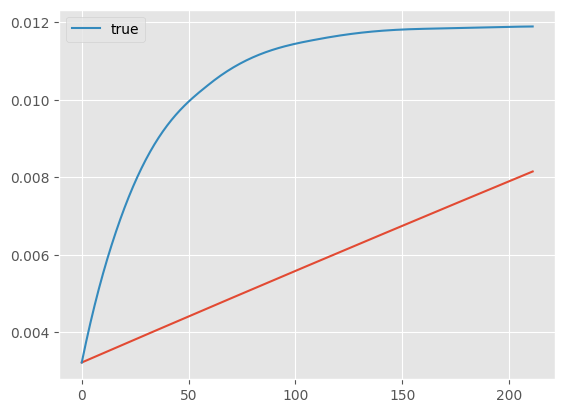

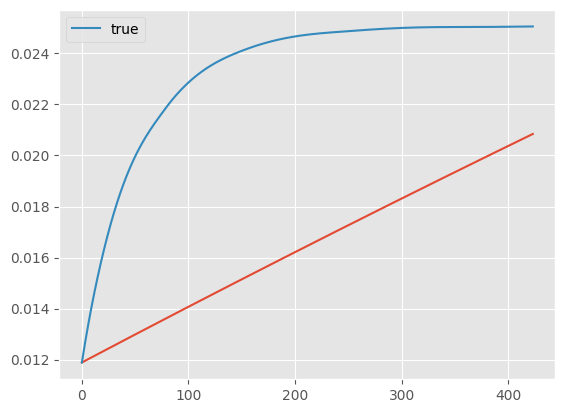

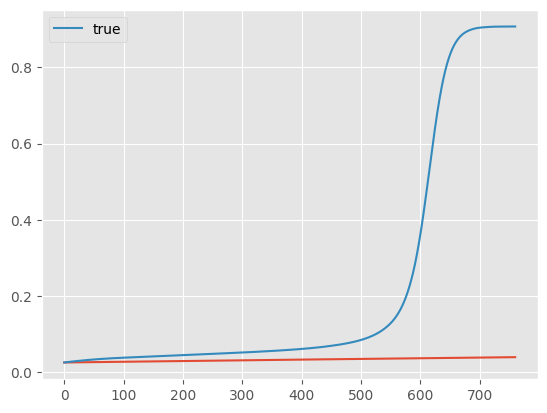

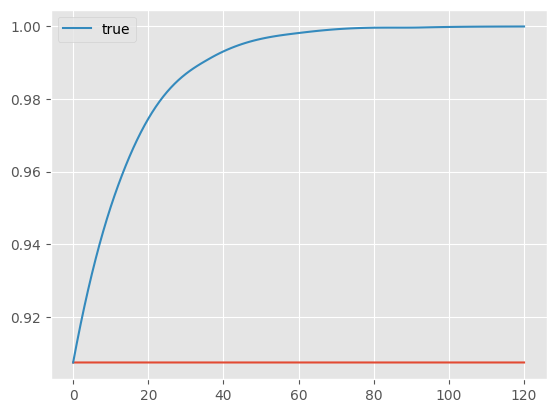

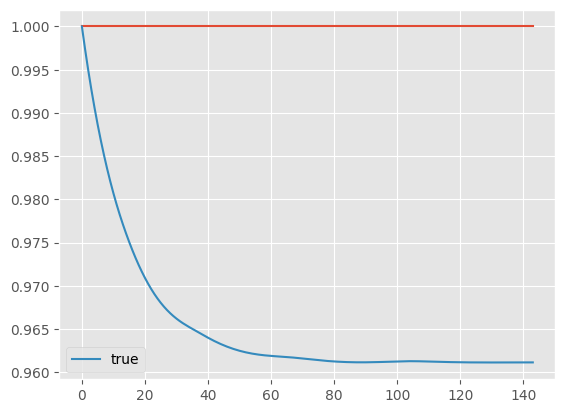

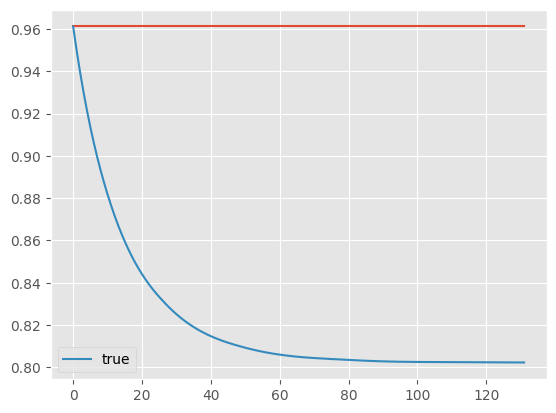

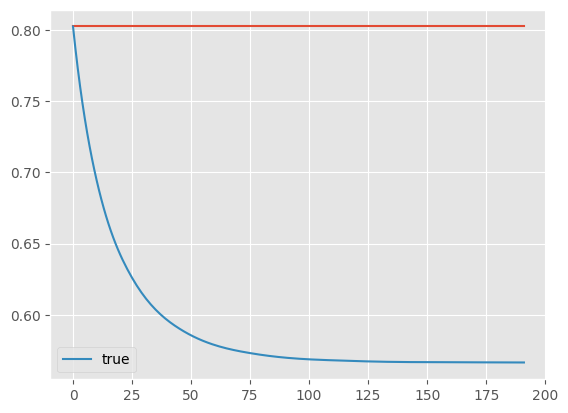

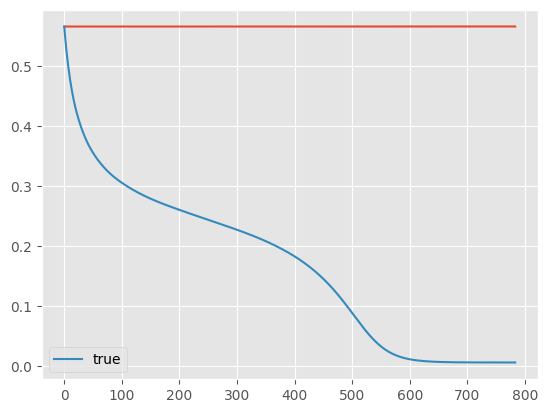

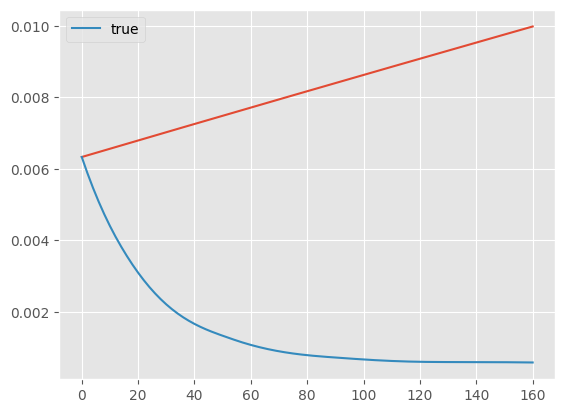

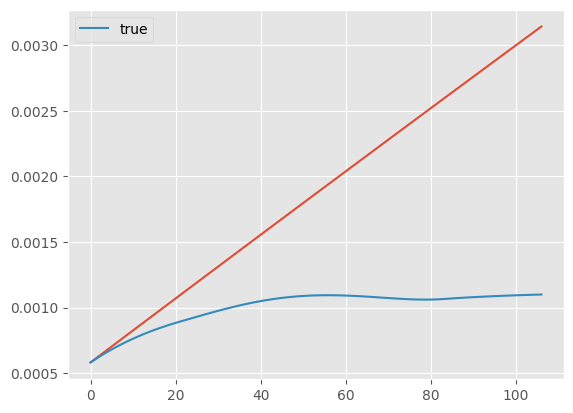

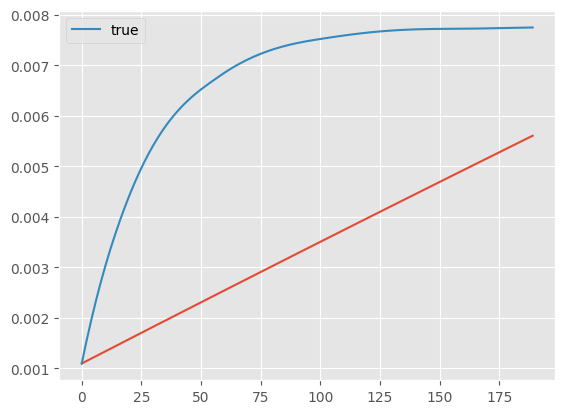

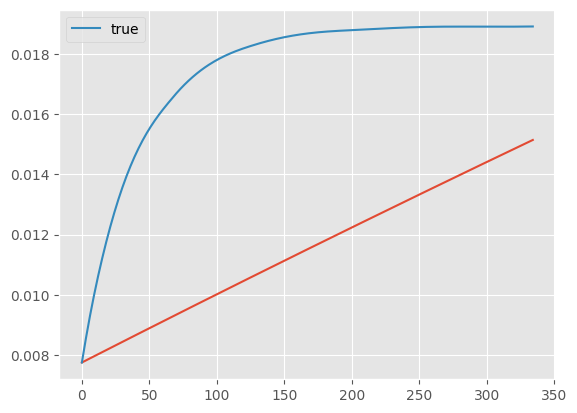

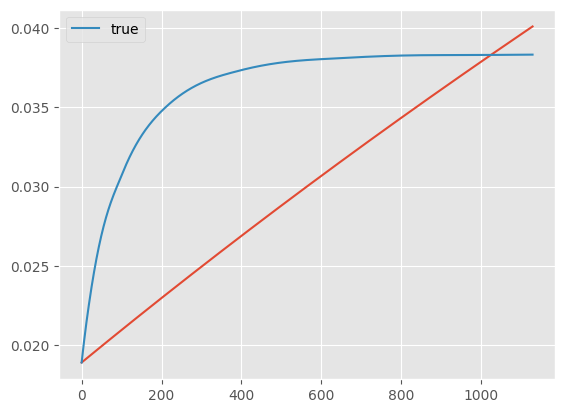

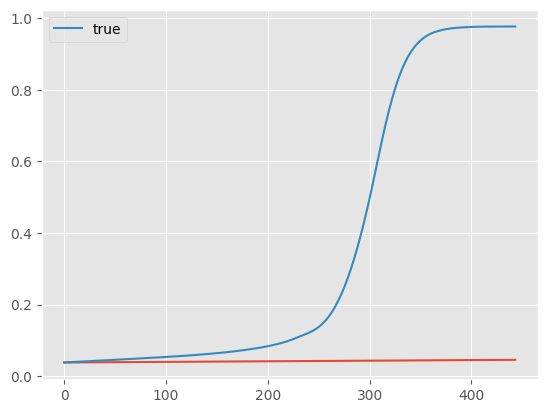

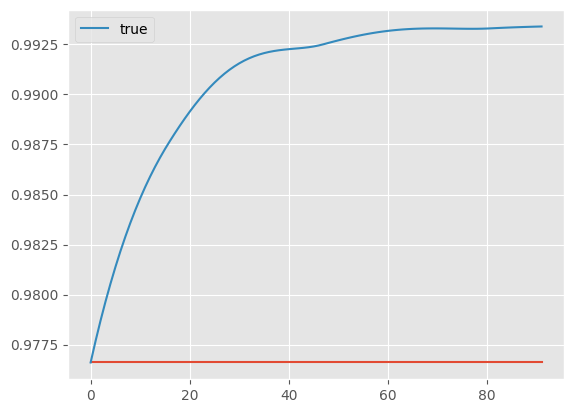

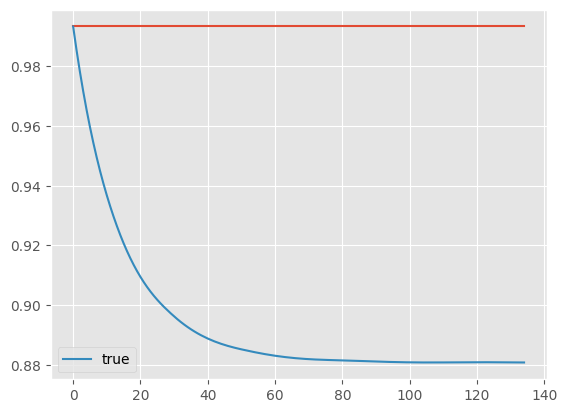

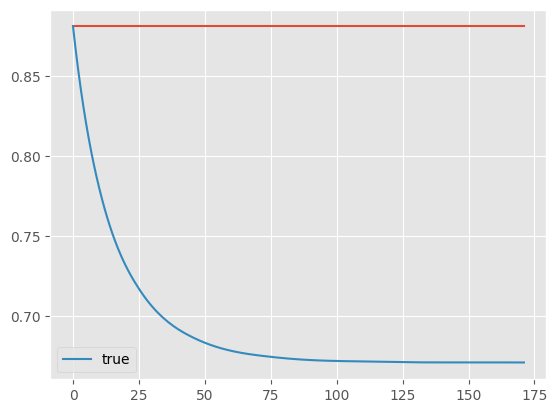

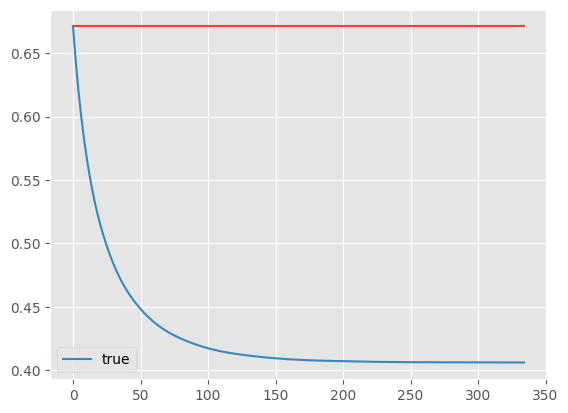

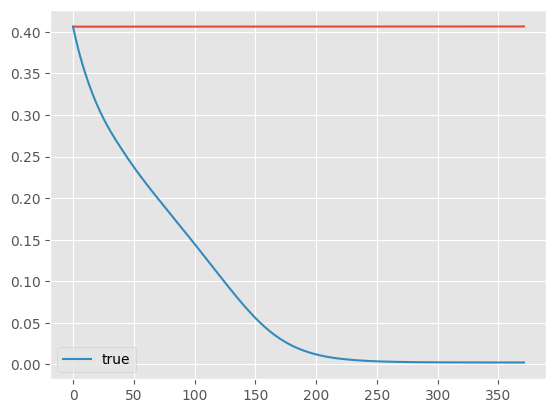

In [ ]:
with torch.no_grad():
    for Xi, Ti, x0i in loop_wrapper2(new_loader):
        Xi = Xi.squeeze() # [batch, time, dim]
        Ti = Ti.squeeze()
        x0i = x0i.reshape(-1,1)

        # if not x0i.requires_grad:
        #     x0i = x0i.clone().detach().requires_grad_()

        sol = solve_ivp(
            f=lambda t, x: model(t, x, control_func),
            y0=x0i,
            t_eval=Ti,
            method=solve_method
        )
        plt.plot(Ti,sol.ys.squeeze())
        plt.plot(Ti,..Xi,label='true')
        plt.legend()
        plt.show()

## to do
- Learn on regular torchode model
 -> output diagnostics
- Learn on Weak SINDy
- plot learned g for fixed k values
- try multiple pertubations?
- Fixed constant g for a constant a given k 
- Try affine g
- Try sigmoidal g 
